In [14]:
import pandas as pd
import numpy as np
from prophet import Prophet
from datetime import datetime  # 🔹 NEW: to record model run datetime
import os  # for checking file existence

# === Step 1: Load data ===
file_path = "C:/GitHub/Machine-Learning/data/BCM_DATA.csv"
df = pd.read_csv(file_path, parse_dates=["ACC_MONTH"])
df = df.dropna(subset=["ACC_MONTH"])
df = df.sort_values("ACC_MONTH")

# Prepare columns
df['ds'] = df['ACC_MONTH']
df['y'] = df['TOT_PAID']
regressors = ['BUDGET_AMT', 'NBR_MURDER']
forecast_horizon = 18


# === Step 2: Forecast each regressor normally ===
regressor_forecasts = {}

for reg in regressors:
    reg_df = df[['ds', reg]].rename(columns={reg: 'y'}).copy()

    # Fit Prophet on historical data
    reg_model = Prophet(yearly_seasonality=True,changepoint_prior_scale=0.8)
    reg_model.fit(reg_df)

    total_needed = forecast_horizon + 3
    reg_future = reg_model.make_future_dataframe(periods=total_needed, freq='ME')
    reg_forecast = reg_model.predict(reg_future)
    reg_forecast = reg_forecast[['ds', 'yhat']].rename(columns={'yhat': reg})

    # Apply change rate only to future values
    last_date = df['ds'].max()
    forecast_start = last_date + pd.offsets.MonthEnd(1)
    future_mask = reg_forecast['ds'] >= forecast_start

    
    regressor_forecasts[reg] = reg_forecast

    # # === Plot regressor trend ===
    # plt.figure(figsize=(10, 4))
    # plt.plot(reg_df['ds'], reg_df['y'], label=f'Historical {reg}', linewidth=2)
    # plt.plot(reg_forecast['ds'], reg_forecast[reg], '--', label=f'Forecasted {reg}', linewidth=2)
    # plt.axvline(x=last_date, color='red', linestyle='--', label='Forecast Start')
    # plt.title(f"{reg} - Forecasted with Future Change Rate")
    # plt.xlabel("Date")
    # plt.ylabel(reg)
    # plt.legend()
    # plt.grid(True)
    # plt.tight_layout()
    # plt.show()

# === Step 3: Merge full regressor forecasts ===
full_df = df[['ds', 'y']].copy()
for reg in regressors:
    full_df = full_df.merge(regressor_forecasts[reg], on='ds', how='outer')

# Fill missing and sort
full_df = full_df.sort_values('ds')
full_df[regressors] = full_df[regressors].ffill()

# === Step 4: Train Prophet model on TOT_PAID and record datetime ===
model_run_datetime = datetime.now().strftime("%Y-%m-%d %H:%M:%S")  # 🔹 capture datetime as string

train_df = full_df[full_df['y'].notnull()].dropna(subset=regressors).copy()
model = Prophet(yearly_seasonality=True,changepoint_prior_scale=0.8)
for reg in regressors:
    model.add_regressor(reg)
model.fit(train_df)

# === Step 5: Generate predictions ===
in_sample = model.predict(train_df[["ds"] + regressors])
in_sample['source'] = 'Fitted'

# === Step 5.1: Evaluate in-sample prediction accuracy ===
def calculate_accuracy_metrics(actual, predicted):
    """Return MAPE, MAE, and RMSE"""
    mask = (~actual.isna()) & (~predicted.isna())
    actual, predicted = actual[mask], predicted[mask]

    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    mae = np.mean(np.abs(actual - predicted))
    rmse = np.sqrt(np.mean((actual - predicted) ** 2))
    return mape, mae, rmse

# Merge actual and predicted values from in_sample
eval_df = train_df[['ds', 'y']].merge(
    in_sample[['ds', 'yhat']], on='ds', how='left'
)

mape, mae, rmse = calculate_accuracy_metrics(eval_df['y'], eval_df['yhat'])

print("\n📈 In-Sample Accuracy Metrics:")
print(f"✅ MAPE: {mape:.2f}%")
print(f"✅ MAE:  {mae:,.2f}")
print(f"✅ RMSE: {rmse:,.2f}")



# Create future_df: only rows beyond the last date in original data
future_df = full_df[full_df['ds'] > df['ds'].max()].copy()
future_df = future_df[["ds"] + regressors]

forecast = model.predict(future_df)
forecast['source'] = 'Forecast'

# === Step 6: Save plot-ready forecast data ===
plot_data = pd.DataFrame({'ds': full_df['ds']})
plot_data = plot_data.merge(df[['ds', 'TOT_PAID']].rename(columns={'TOT_PAID': 'Actual_TOT_PAID'}), on='ds', how='left')

plot_preds = pd.concat([in_sample[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'source']],
                        forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'source']]])
plot_preds = plot_preds.rename(columns={
    'yhat': 'Prediction_TOT_PAID',
    'yhat_lower': 'Prediction_TOT_PAID_lower',
    'yhat_upper': 'Prediction_TOT_PAID_upper'
})
plot_data = plot_data.merge(plot_preds, on='ds', how='left')

for reg in regressors:
    actual_reg = df[['ds', reg]].rename(columns={reg: f'Actual_{reg}'})
    forecasted_reg = regressor_forecasts[reg][['ds', reg]].rename(columns={reg: f'Forecast_{reg}'})
    plot_data = plot_data.merge(actual_reg, on='ds', how='left')
    plot_data = plot_data.merge(forecasted_reg, on='ds', how='left')

# 🔹 Add model run datetime as a new column
plot_data['model_run_datetime'] = model_run_datetime

# # Save to CSV
# plot_data = plot_data.sort_values('ds')
# plot_ready_path = "C:/GitHub/Machine-Learning/data/Plot_Ready_Forecast_Data.csv"
# plot_data.to_csv(plot_ready_path, index=False)
# print(f"\n📁 Plot-ready dataset saved to: {plot_ready_path}")
# print(f"📅 Model run datetime: {model_run_datetime}")



# === Step 7: Load the CSV file ===
file_path = r"C:\GitHub\Machine-Learning\data\Plot_Ready_Forecast_Data.csv"
df = pd.read_csv(file_path, parse_dates=['ds'])
df['model_run_datetime'] = pd.to_datetime(df['model_run_datetime'],format = 'mixed')
latest_model_run = df['model_run_datetime'].max()
latest_df = df[df['model_run_datetime'] == latest_model_run].copy()
print(f"✅ Filtered {len(latest_df)} rows from the latest model run: {latest_model_run}")
#print(latest_df.tail())

# === Step 8: Calculate MAPE and conditionally append ===
# === Step 8: Calculate MAPE between forecasted values in plot_data and latest_df ===

def calculate_mape(actual, predicted):
    """Calculate Mean Absolute Percentage Error"""
    mask = (actual != 0) & (~actual.isna()) & (~predicted.isna())
    return np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask])) * 100

# Filter both dataframes to only include forecasted values
forecast_plot_data = plot_data[plot_data['source'] == 'Forecast'][['ds', 'Prediction_TOT_PAID']].rename(
    columns={'Prediction_TOT_PAID': 'plot_pred'})
forecast_latest_df = latest_df[latest_df['source'] == 'Forecast'][['ds', 'Prediction_TOT_PAID']].rename(
    columns={'Prediction_TOT_PAID': 'latest_pred'})

# Merge on 'ds' to compare corresponding forecasted predictions
merged_forecast = pd.merge(forecast_plot_data, forecast_latest_df, on='ds', how='inner')

# Calculate MAPE between the two sets of forecasted predictions
mape = calculate_mape(merged_forecast['latest_pred'], merged_forecast['plot_pred'])

print(f"\n📊 MAPE between current and latest forecasted TOT_PAID: {mape:.2f}%")

if mape >= 0.1:
    # Append current plot_data to existing dataset
    full_path = r"C:\GitHub\Machine-Learning\data\Plot_Ready_Forecast_Data.csv"
    
    # Load old data
    old_df = pd.read_csv(full_path, parse_dates=['ds'])
    
    # Append new forecast
    combined_df = pd.concat([old_df, plot_data], ignore_index=True)
    combined_df.to_csv(full_path, index=False)

    print(f"📁 MAPE ≥ 5%. New forecast data appended to {full_path}")
else:
    print("✅ MAPE < 5%. Forecast is similar to the latest run. No update made.")



11:27:15 - cmdstanpy - INFO - Chain [1] start processing
11:27:16 - cmdstanpy - INFO - Chain [1] done processing
11:27:16 - cmdstanpy - INFO - Chain [1] start processing
11:27:16 - cmdstanpy - INFO - Chain [1] done processing
11:27:16 - cmdstanpy - INFO - Chain [1] start processing
11:27:16 - cmdstanpy - INFO - Chain [1] done processing



📈 In-Sample Accuracy Metrics:
✅ MAPE: 14.81%
✅ MAE:  265,421.91
✅ RMSE: 338,575.85
✅ Filtered 188 rows from the latest model run: 2025-04-13 11:26:47

📊 MAPE between current and latest forecasted TOT_PAID: 0.00%
✅ MAPE < 5%. Forecast is similar to the latest run. No update made.


Based on the Model's run time:  2025-04-13 11:26:47
the last Actual data in the model:  2025-02-28 00:00:00


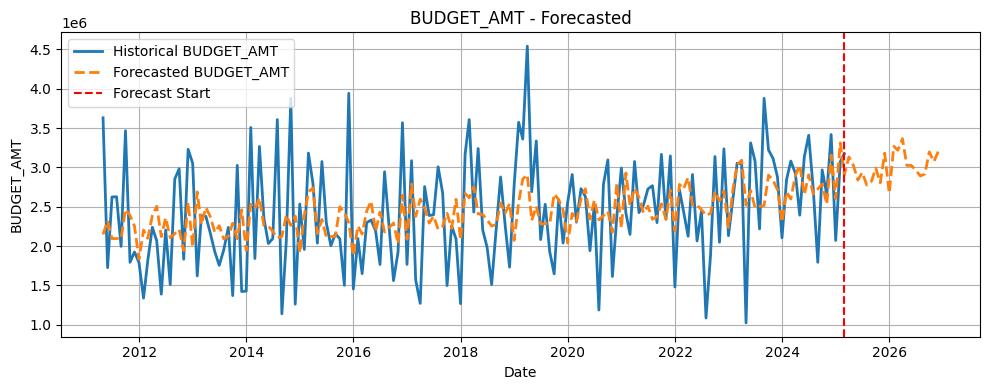

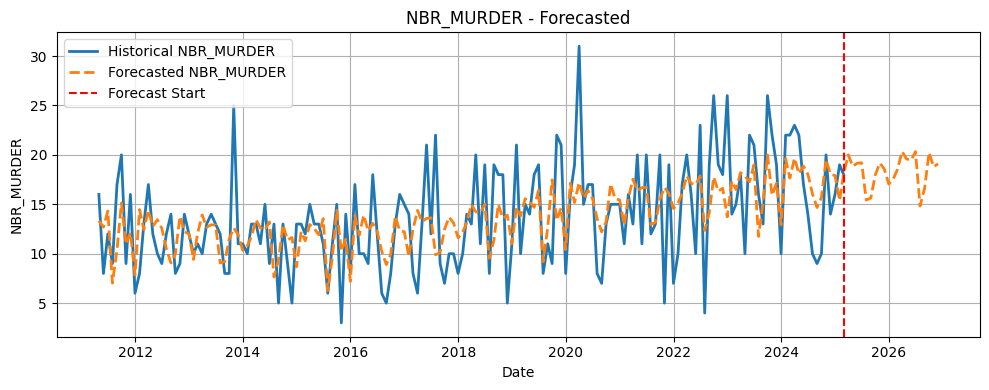

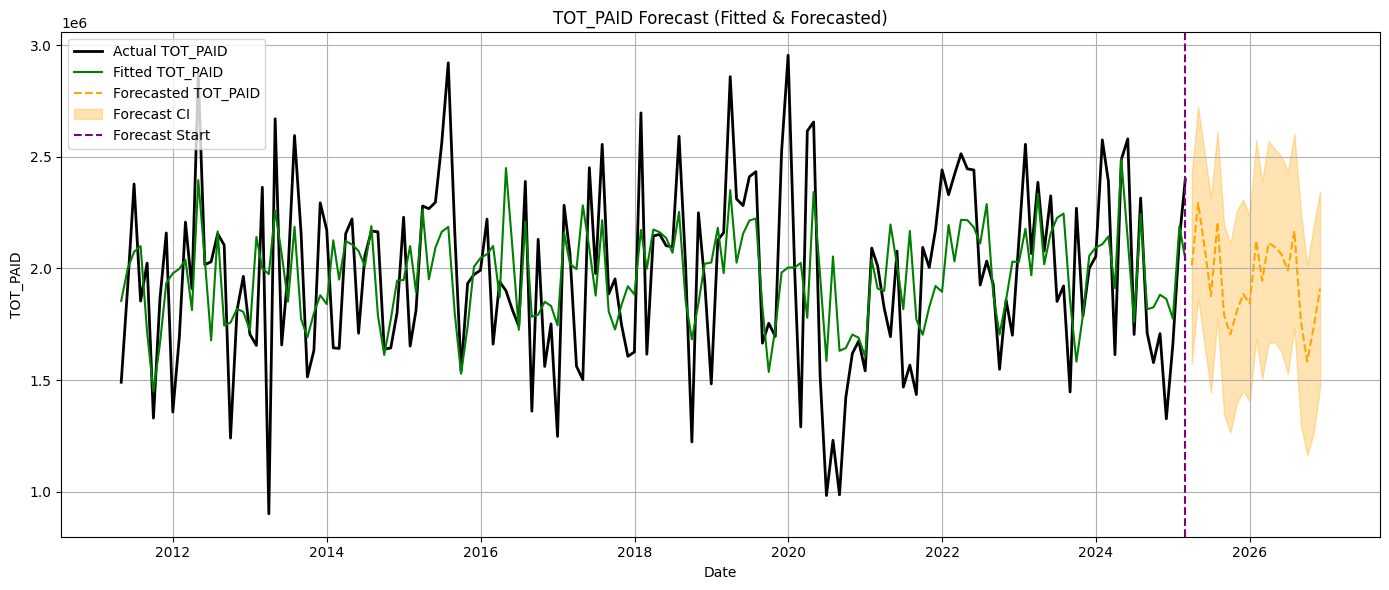

In [15]:
# === Step 11: Recreate plots from saved plot-ready dataset ===

import pandas as pd
import matplotlib.pyplot as plt

# Load saved dataset
plot_data_path = "C:/GitHub/Machine-Learning/data/Plot_Ready_Forecast_Data.csv"
plot_df = pd.read_csv(plot_data_path, parse_dates=["ds"])
plot_df['model_run_datetime'] = pd.to_datetime(plot_df['model_run_datetime'],format = 'mixed')
latest_model_run = plot_df['model_run_datetime'].max()

# === Step 3: Filter the dataframe based on the latest model run datetime ===
plot_df = plot_df[plot_df['model_run_datetime'] == latest_model_run].copy()
print("Based on the Model's run time: ", latest_model_run)

# Get last date of actuals to mark forecast start
last_actual_date = plot_df[plot_df['Actual_TOT_PAID'].notnull()]['ds'].max()
print("the last Actual data in the model: ",last_actual_date)

# === Plot Regressor Forecasts ===
regressors = ['BUDGET_AMT', 'NBR_MURDER']

for reg in regressors:
    plt.figure(figsize=(10, 4))
    plt.plot(plot_df['ds'], plot_df[f'Actual_{reg}'], label=f'Historical {reg}', linewidth=2)
    plt.plot(plot_df['ds'], plot_df[f'Forecast_{reg}'], '--', label=f'Forecasted {reg}', linewidth=2)
    plt.axvline(x=last_actual_date, color='red', linestyle='--', label='Forecast Start')
    plt.title(f"{reg} - Forecasted")
    plt.xlabel("Date")
    plt.ylabel(reg)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Plot TOT_PAID Forecast (Fitted + Forecasted) ===
plt.figure(figsize=(14, 6))
plt.plot(plot_df['ds'], plot_df['Actual_TOT_PAID'], label='Actual TOT_PAID', color='black', linewidth=2)

# Split fitted and forecasted data
fitted_df = plot_df[plot_df['source'] == 'Fitted']
forecast_df = plot_df[plot_df['source'] == 'Forecast']

plt.plot(fitted_df['ds'], fitted_df['Prediction_TOT_PAID'], label='Fitted TOT_PAID', color='green')
plt.plot(forecast_df['ds'], forecast_df['Prediction_TOT_PAID'], '--', label='Forecasted TOT_PAID', color='orange')

# Confidence interval for forecast
plt.fill_between(forecast_df['ds'],
                 forecast_df['Prediction_TOT_PAID_lower'],
                 forecast_df['Prediction_TOT_PAID_upper'],
                 color='orange', alpha=0.3, label='Forecast CI')

plt.axvline(x=last_actual_date, color='purple', linestyle='--', label='Forecast Start')
plt.title("TOT_PAID Forecast (Fitted & Forecasted)")
plt.xlabel("Date")
plt.ylabel("TOT_PAID")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


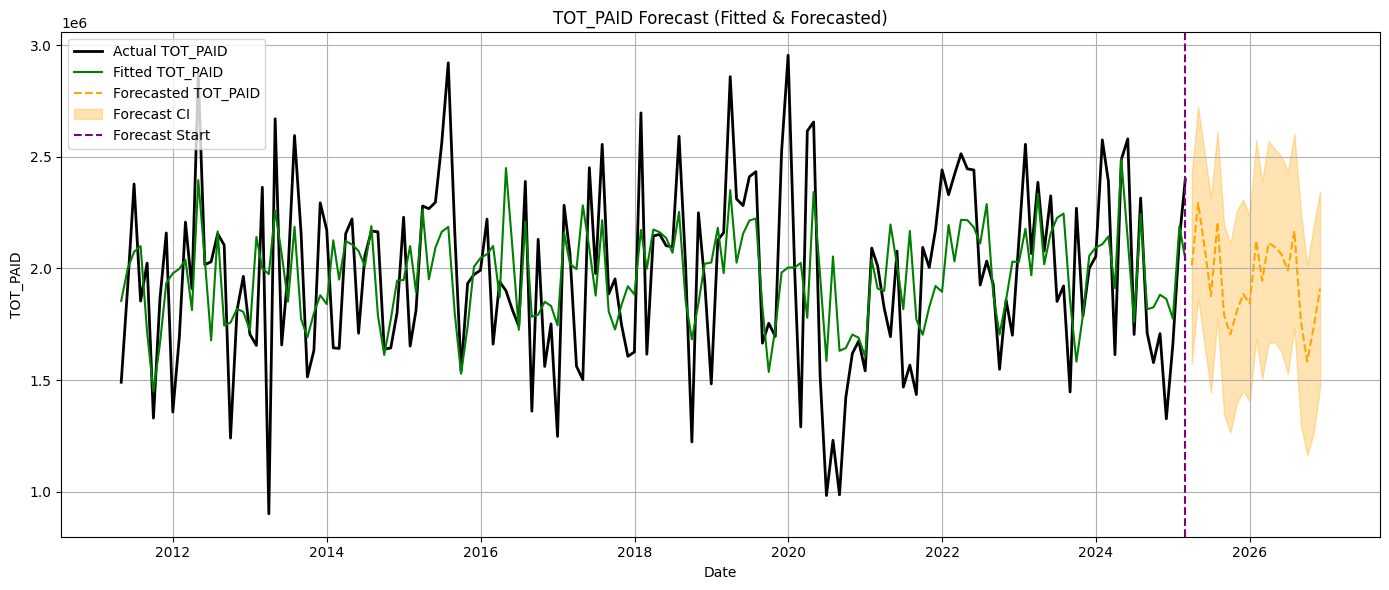

In [16]:
#adjusted for PowerBI
# Total Paid Forecast
import matplotlib.pyplot as plt

# Power BI automatically provides the dataset as 'dataset'
import pandas as pd
dataset = plot_df # should be removed when the code moved to PowerBI
dataset['ds'] = pd.to_datetime(dataset['ds'])
dataset['model_run_datetime'] = pd.to_datetime(dataset['model_run_datetime'], errors='coerce')

# Filter to latest model run
latest_model_run = dataset['model_run_datetime'].max()
plot_df = dataset[dataset['model_run_datetime'] == latest_model_run].copy()

# Separate fitted and forecasted
fitted_df = plot_df[plot_df['source'] == 'Fitted']
forecast_df = plot_df[plot_df['source'] == 'Forecast']

# Last date of actuals
last_actual_date = plot_df[plot_df['Actual_TOT_PAID'].notnull()]['ds'].max()

# Plot
plt.figure(figsize=(14, 6))
plt.plot(plot_df['ds'], plot_df['Actual_TOT_PAID'], label='Actual TOT_PAID', color='black', linewidth=2)
plt.plot(fitted_df['ds'], fitted_df['Prediction_TOT_PAID'], label='Fitted TOT_PAID', color='green')
plt.plot(forecast_df['ds'], forecast_df['Prediction_TOT_PAID'], '--', label='Forecasted TOT_PAID', color='orange')
plt.fill_between(forecast_df['ds'],
                 forecast_df['Prediction_TOT_PAID_lower'],
                 forecast_df['Prediction_TOT_PAID_upper'],
                 color='orange', alpha=0.3, label='Forecast CI')
plt.axvline(x=last_actual_date, color='purple', linestyle='--', label='Forecast Start')
plt.title("TOT_PAID Forecast (Fitted & Forecasted)")
plt.xlabel("Date")
plt.ylabel("TOT_PAID")
plt.legend()
plt.grid(True)
plt.tight_layout()


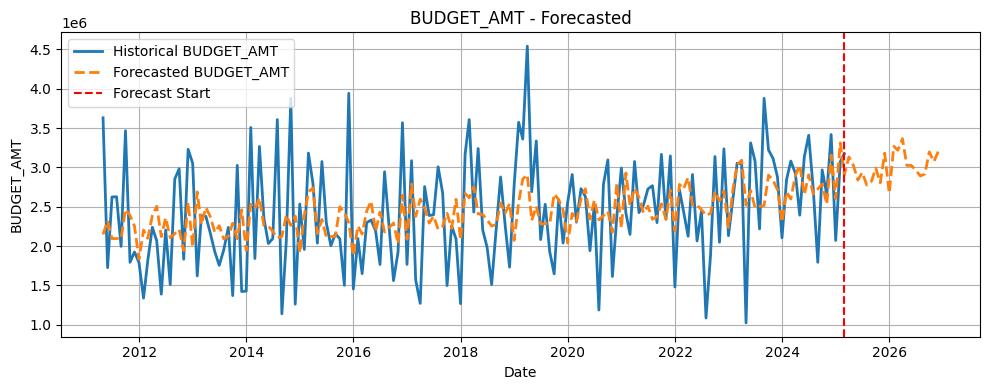

In [17]:
#Budget Forecast
import matplotlib.pyplot as plt
import pandas as pd
dataset = plot_df # should be removed when the code moved to PowerBI
dataset['ds'] = pd.to_datetime(dataset['ds'])
dataset['model_run_datetime'] = pd.to_datetime(dataset['model_run_datetime'], errors='coerce')

latest_model_run = dataset['model_run_datetime'].max()
plot_df = dataset[dataset['model_run_datetime'] == latest_model_run].copy()

last_actual_date = plot_df[plot_df['Actual_BUDGET_AMT'].notnull()]['ds'].max()

plt.figure(figsize=(10, 4))
plt.plot(plot_df['ds'], plot_df['Actual_BUDGET_AMT'], label='Historical BUDGET_AMT', linewidth=2)
plt.plot(plot_df['ds'], plot_df['Forecast_BUDGET_AMT'], '--', label='Forecasted BUDGET_AMT', linewidth=2)
plt.axvline(x=last_actual_date, color='red', linestyle='--', label='Forecast Start')
plt.title("BUDGET_AMT - Forecasted")
plt.xlabel("Date")
plt.ylabel("BUDGET_AMT")
plt.legend()
plt.grid(True)
plt.tight_layout()



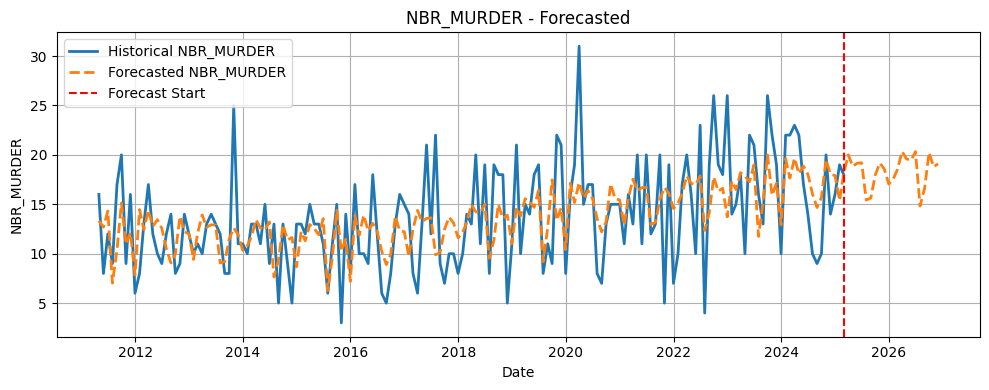

In [18]:
# Nbr of Murder Forecast:

import matplotlib.pyplot as plt
import pandas as pd
dataset = plot_df # should be removed when the code moved to PowerBI
dataset['ds'] = pd.to_datetime(dataset['ds'])
dataset['model_run_datetime'] = pd.to_datetime(dataset['model_run_datetime'], errors='coerce')

latest_model_run = dataset['model_run_datetime'].max()
plot_df = dataset[dataset['model_run_datetime'] == latest_model_run].copy()

last_actual_date = plot_df[plot_df['Actual_NBR_MURDER'].notnull()]['ds'].max()

plt.figure(figsize=(10, 4))
plt.plot(plot_df['ds'], plot_df['Actual_NBR_MURDER'], label='Historical NBR_MURDER', linewidth=2)
plt.plot(plot_df['ds'], plot_df['Forecast_NBR_MURDER'], '--', label='Forecasted NBR_MURDER', linewidth=2)
plt.axvline(x=last_actual_date, color='red', linestyle='--', label='Forecast Start')
plt.title("NBR_MURDER - Forecasted")
plt.xlabel("Date")
plt.ylabel("NBR_MURDER")
plt.legend()
plt.grid(True)
plt.tight_layout()


In [19]:
#Model Accuracy check

import pandas as pd
import numpy as np
from prophet import Prophet
from datetime import datetime

# === Load and prepare data ===
df = pd.read_csv("C:/GitHub/Machine-Learning/data/BCM_DATA.csv", parse_dates=["ACC_MONTH"])
df = df.dropna(subset=["ACC_MONTH"]).sort_values("ACC_MONTH")

df['ds'] = df['ACC_MONTH']
df['y'] = df['TOT_PAID']
regressors = ['BUDGET_AMT', 'NBR_MURDER']

# === Forecast each regressor separately ===
regressor_forecasts = {}
for reg in regressors:
    reg_df = df[['ds', reg]].rename(columns={reg: 'y'}).dropna()
    model = Prophet(yearly_seasonality=True)
    model.fit(reg_df)
    future = model.make_future_dataframe(periods=21, freq='ME')
    forecast = model.predict(future)[['ds', 'yhat']].rename(columns={'yhat': reg})
    regressor_forecasts[reg] = forecast

# === Merge forecasts into main dataset ===
full_df = df[['ds', 'y']].copy()
for reg in regressors:
    full_df = full_df.merge(regressor_forecasts[reg], on='ds', how='outer')
full_df = full_df.sort_values('ds')
full_df[regressors] = full_df[regressors].ffill()

# === 80/20 Train-Test Split ===
data = full_df.dropna(subset=['y'] + regressors)
split_idx = int(len(data) * 0.8)
train_df = data.iloc[:split_idx]
test_df = data.iloc[split_idx:]

# === Train and Predict ===
model = Prophet(yearly_seasonality=True,changepoint_prior_scale=0.1)
for reg in regressors:
    model.add_regressor(reg)
model.fit(train_df)

test_preds = model.predict(test_df[['ds'] + regressors])
test_preds = test_preds[['ds', 'yhat']]

# === Accuracy Evaluation ===
def calculate_accuracy_metrics(actual, predicted):
    mask = (~actual.isna()) & (~predicted.isna())
    actual, predicted = actual[mask], predicted[mask]
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    mae = np.mean(np.abs(actual - predicted))
    rmse = np.sqrt(np.mean((actual - predicted) ** 2))
    return mape, mae, rmse

merged = test_df[['ds', 'y']].merge(test_preds, on='ds')
mape, mae, rmse = calculate_accuracy_metrics(merged['y'], merged['yhat'])

print("\n📊 Test Set Accuracy Metrics (80/20 split):")
print(f"✅ MAPE: {mape:.2f}%")
print(f"✅ MAE:  {mae:,.2f}")
print(f"✅ RMSE: {rmse:,.2f}")



11:27:18 - cmdstanpy - INFO - Chain [1] start processing
11:27:18 - cmdstanpy - INFO - Chain [1] done processing
11:27:19 - cmdstanpy - INFO - Chain [1] start processing
11:27:19 - cmdstanpy - INFO - Chain [1] done processing
11:27:19 - cmdstanpy - INFO - Chain [1] start processing
11:27:19 - cmdstanpy - INFO - Chain [1] done processing



📊 Test Set Accuracy Metrics (80/20 split):
✅ MAPE: 12.92%
✅ MAE:  259,045.87
✅ RMSE: 336,997.43
